In [1]:
import pandas as pd
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from IPython.display import display
import numpy as np
from sklearn import metrics
import matplotlib.pyplot as plt 
from sklearn.metrics import classification_report, roc_auc_score
from sklearn.model_selection import train_test_split
import xgboost as xgb
from xgboost import XGBClassifier
from sklearn.ensemble import AdaBoostClassifier
import lightgbm as lgb


In [2]:
#Import data and join files to create training set
train = pd.read_csv('X_train.csv')

test = pd.read_csv('X_test.csv')

In [3]:
train.head()

,row_id,series_id,measurement_number,orientation_X,orientation_Y,orientation_Z,orientation_W,angular_velocity_X,angular_velocity_Y,angular_velocity_Z,linear_acceleration_X,linear_acceleration_Y,linear_acceleration_Z
0,0_0,0,0,-0.75853,-0.63435,-0.10488,-0.10597,0.107650,0.017561,0.000767,-0.74857,2.1030,-9.7532
1,0_1,0,1,-0.75853,-0.63434,-0.10490,-0.10600,0.067851,0.029939,0.003385,0.33995,1.5064,-9.4128
2,0_2,0,2,-0.75853,-0.63435,-0.10492,-0.10597,0.007275,0.028934,-0.005978,-0.26429,1.5922,-8.7267
3,0_3,0,3,-0.75852,-0.63436,-0.10495,-0.10597,-0.013053,0.019448,-0.008974,0.42684,1.0993,-10.0960
4,0_4,0,4,-0.75852,-0.63435,-0.10495,-0.10596,0.005135,0.007652,0.005245,-0.50969,1.4689,-10.4410


In [4]:
def quaternion_to_euler(x, y, z, w):
    import math
    t0 = +2.0 * (w * x + y * z)
    t1 = +1.0 - 2.0 * (x * x + y * y)
    X = math.atan2(t0, t1)

    t2 = +2.0 * (w * y - z * x)
    t2 = +1.0 if t2 > +1.0 else t2
    t2 = -1.0 if t2 < -1.0 else t2
    Y = math.asin(t2)

    t3 = +2.0 * (w * z + x * y)
    t4 = +1.0 - 2.0 * (y * y + z * z)
    Z = math.atan2(t3, t4)

    return X, Y, Z

## Feature engineering 1

### Train data

In [5]:
train['angular_velocity'] = train['angular_velocity_X'] + train['angular_velocity_Y'] + train['angular_velocity_Z']
train['linear_acceleration'] = train['linear_acceleration_X'] + train['linear_acceleration_Y'] + train['linear_acceleration_Z']
train['velocity_to_acceleration'] = train['angular_velocity'] / train['linear_acceleration']
train['angular_velocity_diag'] = (train['angular_velocity_X']**2 + train['angular_velocity_Y']**2 + train['angular_velocity_Z']**2)**(1.0/2.0)
train['linear_acceleration_diag'] = (train['linear_acceleration_X']**2 + train['linear_acceleration_Y']**2 + train['linear_acceleration_Z']**2)**(1.0/2.0)
train['acc_vs_vel'] = train['linear_acceleration_diag'] / train['angular_velocity_diag'] 



In [6]:
x, y, z, w = train['orientation_X'].tolist(), train['orientation_Y'].tolist(), train['orientation_Z'].tolist(), train['orientation_W'].tolist()
nx, ny, nz = [], [], []
for i in range(len(x)):
    xx, yy, zz = quaternion_to_euler(x[i], y[i], z[i], w[i])
    nx.append(xx)
    ny.append(yy)
    nz.append(zz)
    
train['euler_x'] = nx
train['euler_y'] = ny
train['euler_z'] = nz

In [7]:
train['total_angle'] = (train['euler_x'] ** 2 + train['euler_y'] ** 2 + train['euler_z'] ** 2) ** 5
train['angle_vs_acc'] = train['total_angle'] / train['linear_acceleration_diag']
train['angle_vs_vel'] = train['total_angle'] / train['angular_velocity_diag']

In [8]:
train.shape

(487680, 25)

In [9]:
train_grouped = pd.DataFrame()
for col in train.columns[3:]:
        train_grouped[col + '_mean'] = train.groupby(['series_id'])[col].mean()
        train_grouped[col + '_std'] = train.groupby(['series_id'])[col].std()
        train_grouped[col + '_max'] = train.groupby(['series_id'])[col].max()
        train_grouped[col + '_min'] = train.groupby(['series_id'])[col].min()
        train_grouped[col + '_max_to_min'] = train_grouped[col + '_max'] / train_grouped[col + '_min']
        train_grouped[col + '_quant25'] = train.groupby(['series_id'])[col].quantile(0.25)
        train_grouped[col + '_quant75'] = train.groupby(['series_id'])[col].quantile(0.75)
        train_grouped[col + '_quant50'] = train.groupby(['series_id'])[col].quantile(0.50)
        
        train_grouped[col + '_mean_abs_change'] = train.groupby('series_id')[col].apply(lambda x: np.mean(np.abs(np.diff(x))))
        train_grouped[col + '_abs_max'] = train.groupby('series_id')[col].apply(lambda x: np.max(np.abs(x)))
        train_grouped[col + '_abs_min'] = train.groupby('series_id')[col].apply(lambda x: np.min(np.abs(x)))
        train_grouped[col + '_mean_change_of_abs_change'] = train.groupby('series_id')[col].apply(lambda x: np.mean(np.diff(np.abs(np.diff(x)))))

In [10]:
train_grouped.head()

,orientation_X_mean,orientation_X_std,orientation_X_max,orientation_X_min,orientation_X_max_to_min,orientation_X_quant25,orientation_X_quant75,orientation_X_quant50,orientation_X_mean_abs_change,orientation_X_abs_max,...,angle_vs_vel_max,angle_vs_vel_min,angle_vs_vel_max_to_min,angle_vs_vel_quant25,angle_vs_vel_quant75,angle_vs_vel_quant50,angle_vs_vel_mean_abs_change,angle_vs_vel_abs_max,angle_vs_vel_abs_min,angle_vs_vel_mean_change_of_abs_change
series_id,,,,,,,,,,,,,,,,,,,,,
0,-0.758666,0.000363,-0.75822,-0.75953,0.998275,-0.758927,-0.758367,-0.758530,0.000015,0.75953,...,9.597909e+06,6.255962e+05,15.342019,1.369929e+06,2.846509e+06,1.927821e+06,1.198969e+06,9.597909e+06,6.255962e+05,8924.000999
1,-0.958606,0.000151,-0.95837,-0.95896,0.999385,-0.958720,-0.958480,-0.958595,0.000023,0.95896,...,1.957088e+06,1.377975e+05,14.202636,2.788236e+05,5.237909e+05,3.917496e+05,2.049951e+05,1.957088e+06,1.377975e+05,569.164381
2,-0.512057,0.001377,-0.50944,-0.51434,0.990473,-0.513110,-0.510947,-0.512035,0.000041,0.51434,...,2.866679e+07,1.674839e+06,17.116144,3.082358e+06,5.938406e+06,4.237554e+06,2.355426e+06,2.866679e+07,1.674839e+06,-9135.272306
3,-0.939169,0.000227,-0.93884,-0.93968,0.999106,-0.939340,-0.938960,-0.939170,0.000026,0.93968,...,3.121275e+06,8.652378e+04,36.074189,2.076787e+05,5.763665e+05,3.491645e+05,2.981020e+05,3.121275e+06,8.652378e+04,17412.401283
4,-0.891301,0.002955,-0.88673,-0.89689,0.988672,-0.893795,-0.888750,-0.890940,0.000080,0.89689,...,6.165090e+05,2.330043e+05,2.645912,3.011370e+05,4.294299e+05,3.461069e+05,2.281891e+04,6.165090e+05,2.330043e+05,-70.793166


In [11]:
train_grouped.fillna(0, inplace = True)
train_grouped.replace(-np.inf, 0, inplace = True)
train_grouped.replace(np.inf, 0, inplace = True)

### Test data

In [12]:
test['angular_velocity'] = test['angular_velocity_X'] + test['angular_velocity_Y'] + test['angular_velocity_Z']
test['linear_acceleration'] = test['linear_acceleration_X'] + test['linear_acceleration_Y'] + test['linear_acceleration_Z']
test['velocity_to_acceleration'] = test['angular_velocity'] / test['linear_acceleration']
test['angular_velocity_diag'] = (test['angular_velocity_X']**2 + test['angular_velocity_Y']**2 + test['angular_velocity_Z']**2)**(1.0/2.0)
test['linear_acceleration_diag'] = (test['linear_acceleration_X']**2 + test['linear_acceleration_Y']**2 + test['linear_acceleration_Z']**2)**(1.0/2.0)
test['acc_vs_vel'] = test['linear_acceleration_diag'] / test['angular_velocity_diag'] 


In [13]:
x, y, z, w = test['orientation_X'].tolist(), test['orientation_Y'].tolist(), test['orientation_Z'].tolist(), test['orientation_W'].tolist()
nx, ny, nz = [], [], []
for i in range(len(x)):
    xx, yy, zz = quaternion_to_euler(x[i], y[i], z[i], w[i])
    nx.append(xx)
    ny.append(yy)
    nz.append(zz)
    
test['euler_x'] = nx
test['euler_y'] = ny
test['euler_z'] = nz

In [14]:
test['total_angle'] = (test['euler_x'] ** 2 + test['euler_y'] ** 2 + test['euler_z'] ** 2) ** 5
test['angle_vs_acc'] = test['total_angle'] / test['linear_acceleration_diag']
test['angle_vs_vel'] = test['total_angle'] / test['angular_velocity_diag']

In [15]:
test_grouped = pd.DataFrame()
for col in test.columns[3:]:
        test_grouped[col + '_mean'] = test.groupby(['series_id'])[col].mean()
        test_grouped[col + '_std'] = test.groupby(['series_id'])[col].std()
        test_grouped[col + '_max'] = test.groupby(['series_id'])[col].max()
        test_grouped[col + '_min'] = test.groupby(['series_id'])[col].min()
        test_grouped[col + '_max_to_min'] = test_grouped[col + '_max'] / test_grouped[col + '_min']
        test_grouped[col + '_quant25'] = test.groupby(['series_id'])[col].quantile(0.25)
        test_grouped[col + '_quant75'] = test.groupby(['series_id'])[col].quantile(0.75)
        test_grouped[col + '_quant50'] = test.groupby(['series_id'])[col].quantile(0.50)
        
        test_grouped[col + '_mean_abs_change'] = test.groupby('series_id')[col].apply(lambda x: np.mean(np.abs(np.diff(x))))
        test_grouped[col + '_abs_max'] = test.groupby('series_id')[col].apply(lambda x: np.max(np.abs(x)))
        test_grouped[col + '_abs_min'] = test.groupby('series_id')[col].apply(lambda x: np.min(np.abs(x)))
        test_grouped[col + '_mean_change_of_abs_change'] = test.groupby('series_id')[col].apply(lambda x: np.mean(np.diff(np.abs(np.diff(x)))))

In [16]:
test_grouped.fillna(0, inplace = True)

test_grouped.replace(-np.inf, 0, inplace = True)
test_grouped.replace(np.inf, 0, inplace = True)

## Labels

In [17]:
target = pd.read_csv('y_train.csv')

In [18]:
#Create target variable
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
target['surface'] = le.fit_transform(target['surface'])

In [19]:
target.head()

,series_id,group_id,surface
0,0,13,2
1,1,31,1
2,2,20,1
3,3,31,1
4,4,22,6


## Model using LGBM

In [61]:
params = {
    'num_leaves': 18,
    'min_data_in_leaf': 40,
    'objective': 'multiclass',
    'metric': 'multi_error',
    'max_depth': 8,
    'learning_rate': 0.01,
    "boosting": "gbdt",
    "bagging_freq": 5,
    "bagging_fraction": 0.8126672064208567,
    "bagging_seed": 11,
    "verbosity": -1,
    'reg_alpha': 0.1,
    'reg_lambda': 0,
    "num_class": 9,
    'nthread': -1
}

In [62]:
train_set = lgb.Dataset(train_grouped, label=target)
eval_hist = lgb.cv(params, train_set, nfold=10, num_boost_round=9999, early_stopping_rounds=100, seed=19)

In [68]:
len(eval_hist['multi_error-mean'])

1711

In [69]:
num_rounds = len(eval_hist['multi_error-mean'])
# retrain the model and make predictions for test set
clf = lgb.train(params, train_set, num_boost_round=num_rounds)

In [75]:
predictions = clf.predict(test_grouped, num_iteration=None)

In [76]:
submission = pd.read_csv('sample_submission.csv')

In [77]:
submission['surface'] = le.inverse_transform(predictions.argmax(axis=1))
#submission['surface'] = predictions.argmax(axis=1)

In [78]:
submission.head()

,series_id,surface
0,0,hard_tiles_large_space
1,1,concrete
2,2,tiled
3,3,carpet
4,4,soft_tiles


In [74]:
submission.to_csv('submission lgbm features engg 3.csv')

### Importances

In [184]:
importance = pd.DataFrame({'gain': clf.feature_importance(importance_type='gain'),
                           'feature': clf.feature_name()})

In [185]:
importance.sort_values(by='gain', ascending=False, inplace=True)

In [186]:
importance['pc'] = (importance['gain'] * 100) / importance.gain.sum()

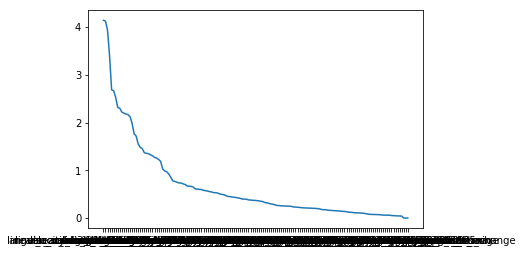

In [187]:
plt.plot(importance.feature, importance.pc)


In [188]:
important_features = importance[importance['pc'] > 0.7]['feature']

In [138]:
important_features.values

array(['orientation_X_min', 'angular_velocity_Y_mean_abs_change',
       'orientation_Z_abs_max', 'angular_velocity_std',
       'linear_acceleration_X_mean_abs_change', 'orientation_W_abs_max',
       'orientation_Z_max', 'linear_acceleration_mean_abs_change',
       'orientation_X_max', 'angular_velocity_quant25',
       'orientation_X_max_to_min', 'orientation_X_abs_max',
       'angular_velocity_diag_mean',
       'linear_acceleration_Y_mean_abs_change', 'orientation_Y_min',
       'linear_acceleration_X_std', 'angular_velocity_Y_abs_max',
       'angular_velocity_Z_min', 'orientation_W_max',
       'velocity_to_acceleration_mean_abs_change',
       'linear_acceleration_Y_std', 'orientation_Y_abs_max',
       'orientation_Y_max_to_min', 'orientation_Z_min',
       'linear_acceleration_Z_quant25', 'orientation_Z_max_to_min',
       'linear_acceleration_Y_max', 'linear_acceleration_Y_min',
       'linear_acceleration_Z_min', 'orientation_W_max_to_min',
       'orientation_Y_max', 'or

### Run on important feature - pc > 0.7

In [189]:
train_set = lgb.Dataset(train_grouped[important_features.values], label=target)
eval_hist = lgb.cv(params, train_set, nfold=10, num_boost_round=9999,
                   early_stopping_rounds=100, seed=19)

In [190]:
num_rounds = len(eval_hist['multi_error-mean'])
# retrain the model and make predictions for test set
clf = lgb.train(params, train_set, num_boost_round=num_rounds)


In [191]:
predictions = clf.predict(test_grouped[important_features.values], num_iteration=None)


In [192]:
submission = pd.read_csv('sample_submission.csv')
#submission['surface'] = le.inverse_transform(predictions.argmax(axis=1))
submission['surface'] = predictions.argmax(axis=1)
submission.to_csv('submission consolidation feature engg grouped imp features 41.csv')

## Model using XGBoost

In [193]:
#Create target variable
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
target = le.fit_transform(y['surface'])

In [194]:
y.surface.value_counts()


concrete                  779
soft_pvc                  732
wood                      607
tiled                     514
fine_concrete             363
hard_tiles_large_space    308
soft_tiles                297
carpet                    189
hard_tiles                 21
Name: surface, dtype: int64

In [196]:
xgbm = XGBClassifier(learning_rate =0.1, n_estimators=1000, max_depth=5, objective= 'multi:softprob',n_jobs=-1, num_class=9)            
xgbm.fit(train_grouped, target)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=5, min_child_weight=1, missing=None, n_estimators=1000,
       n_jobs=-1, nthread=None, num_class=9, objective='multi:softprob',
       random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
       seed=None, silent=True, subsample=1)

In [156]:
train_grouped.shape, target.shape

((3810, 150), (3810,))

In [197]:
#Prediction for xbg test data
#xgb_pred_df = pd.DataFrame(xgbm.predict_proba(test))
xgb_pred_df = xgbm.predict(test_grouped)

In [198]:
xgb_pred_df

array([4, 0, 7, ..., 1, 1, 8])

In [199]:
submission = pd.read_csv('sample_submission.csv')
submission['surface'] = xgb_pred_df

In [200]:
submission.to_csv('submission consolidated xgb.csv')

In [18]:
#Make submission file
s = pd.read_csv('submission consolidated 1.csv')


In [25]:
s = s.merge(labels_df, on='surface', how='left' )

In [27]:
s.to_csv('submission consolidated 1 mapped.csv')

In [15]:
labels_df = pd.DataFrame({'codes':[0,1,2,3,4,5,6,7,8], 'surface':le.inverse_transform([0,1,2,3,4,5,6,7,8])})

In [17]:
labels_df.to_csv('labels.csv')

In [22]:
labels_df.columns = ['surface', 'surface_name']

In [24]:
labels_df

,surface,surface_name
0,0,carpet
1,1,concrete
2,2,fine_concrete
3,3,hard_tiles
4,4,hard_tiles_large_space
5,5,soft_pvc
6,6,soft_tiles
7,7,tiled
8,8,wood


## Using Stratified Folds and RF

In [135]:
import xgboost as xgb
from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.ensemble import RandomForestClassifier

In [157]:
folds = StratifiedKFold(n_splits=16, shuffle=False, random_state=23)

In [161]:
#for j in [10,11,12,13,14,15,16,17,18,19,20,21,22]:
folds = StratifiedKFold(n_splits=16, shuffle=True, random_state=23)
oof_preds = np.zeros((train_grouped.shape[0]))
preds = np.zeros((test_grouped.shape[0],9))
score=0
for i, (train_index, valid_index) in enumerate(folds.split(train_grouped, target['surface'])):
    #print('Fold:',i)
    clf =  RandomForestClassifier(n_estimators = 200, n_jobs = -1)
    clf.fit(train_grouped.iloc[train_index], target['surface'][train_index])
    oof_preds[valid_index] = clf.predict(train_grouped.iloc[valid_index])
    preds += clf.predict_proba(test_grouped) / folds.n_splits
    score += clf.score(train_grouped.iloc[valid_index], target['surface'][valid_index])

'''   print('score ', clf.score(train_grouped.iloc[valid_index], target['surface'][valid_index]))
    importances = clf.feature_importances_
    indices = np.argsort(importances)
    features = train_grouped.columns

    hm = 30
    plt.figure(figsize=(7, 10))
    plt.title('Feature Importances')
    plt.barh(range(len(indices[:hm])), importances[indices][:hm], color='b', align='center')
    plt.yticks(range(len(indices[:hm])), [features[i] for i in indices])
    plt.xlabel('Relative Importance')
    plt.show() '''

print('Folds:', j, 'Avg Accuracy:', score / folds.n_splits)

Folds: 22 Avg Accuracy: 0.9194740265681007


In [163]:
submission = pd.read_csv('sample_submission.csv')

In [165]:
submission['surface'] = le.inverse_transform(preds.argmax(axis=1))

In [167]:
submission.to_csv('submission rf sfold 1.csv')

## Stratified folds and xgb

In [18]:
import xgboost as xgb
from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.ensemble import RandomForestClassifier

In [ ]:
#for j in [10,11,12,13,14,15,16,17,18,19,20,21,22]:
folds = StratifiedKFold(n_splits=10, shuffle=True, random_state=23)
oof_preds = np.zeros((train_grouped.shape[0]))
preds = np.zeros((test_grouped.shape[0],9))
score=0
for i, (train_index, valid_index) in enumerate(folds.split(train_grouped, target['surface'])):
    #print('Fold:',i)
    train_set = xgb.Dataset()
    
    
    
    clf =  RandomForestClassifier(n_estimators = 200, n_jobs = -1)
    clf.fit(train_grouped.iloc[train_index], target['surface'][train_index])
    oof_preds[valid_index] = clf.predict(train_grouped.iloc[valid_index])
    preds += clf.predict_proba(test_grouped) / folds.n_splits
    score += clf.score(train_grouped.iloc[valid_index], target['surface'][valid_index])

'''   print('score ', clf.score(train_grouped.iloc[valid_index], target['surface'][valid_index]))
    importances = clf.feature_importances_
    indices = np.argsort(importances)
    features = train_grouped.columns

    hm = 30
    plt.figure(figsize=(7, 10))
    plt.title('Feature Importances')
    plt.barh(range(len(indices[:hm])), importances[indices][:hm], color='b', align='center')
    plt.yticks(range(len(indices[:hm])), [features[i] for i in indices])
    plt.xlabel('Relative Importance')
    plt.show() '''

print('Folds:', j, 'Avg Accuracy:', score / folds.n_splits)

In [21]:
from sklearn.model_selection import train_test_split

x_train, x_valid, y_train, y_valid = train_test_split(train_grouped, target['surface'], test_size=0.2, random_state=42)

In [22]:
train = xgb.DMatrix(x_train, label=y_train)
valid = xgb.DMatrix(x_valid, label=y_valid)

In [173]:
param = {
    'max_depth': 3,  # the maximum depth of each tree
    'eta': 0.3,  # the training step for each iteration
    'silent': 1,  # logging mode - quiet
    'objective': 'multi:softprob',  # error evaluation for multiclass training
    'num_class': 9}  # the number of classes that exist in this datset
num_round = 100  # the number of training iterations

In [193]:
xgb_model = xgb.train(param, train, num_round)

ZeroDivisionError: integer division or modulo by zero

In [176]:
xgb_preds = xgb_model.predict(valid)

In [179]:
xgb_pred_classes = xgb_preds.argmax(axis=1)

In [181]:
from sklearn.metrics import accuracy_score
accuracy_score(y_valid, xgb_pred_classes)

0.9094488188976378

## Parameter Tuning using Hyperopt

In [56]:
from hyperopt import hp, fmin, tpe, STATUS_OK, Trials
from sklearn.metrics import accuracy_score
def objective(space):
    xgb_model = xgb.train(space, train, num_boost_round=2, objective='multi:softprob', num_class=9)
    xgb_preds = xgb_model.predict(valid)
    xgb_pred_classes = xgb_preds.argmax(axis=1)
    acc = accuracy_score(y_valid, xgb_pred_classes)

    return{'loss':1-acc, 'status': STATUS_OK }

In [58]:
space ={
        'max_depth': hp.choice("max_depth", np.arange(3,6,1)),
        'eta': hp.uniform('eta', 0.2, 0.8),
        'min_child_weight': hp.choice ('min_child_weight', np.arange(1, 10, 1)),
        'subsample': hp.uniform ('subsample', 0.8, 1)
#        'objective': hp.choice('objective', ['multi:softprob']),
#        'num_class': hp.choice('num_class', np.arange(9,9,0))
        }


In [59]:
from hyperopt.pyll.stochastic import sample
sample(space)

{'eta': 0.4926039611015652,
 'max_depth': 5,
 'min_child_weight': 8,
 'subsample': 0.9248935440661906}

In [60]:
trials = Trials()

In [61]:
best = fmin(fn=objective,
            space=space,
            algo=tpe.suggest,
            max_evals=2,
            trials=trials)

print(best)

  0%|                                                                              | 0/2 [00:00<?, ?it/s, best loss: ?]


TypeError: train() got an unexpected keyword argument 'objective'

In [207]:
best

{'eta': 0,
 'max_depth': 3,
 'min_child_weight': 7.0,
 'num_class': 0,
 'objective': 0,
 'subsample': 0.9947606040229142}

In [203]:

sample(space)

{'eta': 0.8,
 'max_depth': 4,
 'min_child_weight': 5.0,
 'num_class': 9,
 'objective': 'multi:softprob',
 'subsample': 0.8361634904995421}